# Summary statistics and kernel density estimation for weather data pulled using the Dark Sky API

This notebook contains some light cleaning and exploratory data analysis using DC weather data from 2010 - 2017.


* Variable definitions - https://darksky.net/dev/docs#response-format



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('darkgrid')
from sklearn.neighbors import KernelDensity

df = pd.read_csv(r'~\git\Bikeshare-DC\data\Dark_Sky_2010_2017.csv', parse_dates=[0], infer_datetime_format=True)
df.shape

(2922, 27)

In [2]:
# creating weather dummies
df = pd.concat([df, pd.get_dummies(df['precipType'])], axis=1)
df.rename(columns = {'rain':'rain_dummy','snow':'snow_dummy'}, inplace = True)

# converting Unix time to human-readable time
timevars = ['apparentTemperatureHighTime','apparentTemperatureLowTime','precipIntensityMaxTime',
           'sunriseTime','sunsetTime','temperatureHighTime','temperatureLowTime', 'time']
for var in timevars:
    df[var] = pd.to_datetime(df[var],unit='s')

# creating time variables for slicing
df['year'] = df['date'].dt.year 
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['weekday_name'] = df['date'].dt.weekday_name
df['quarter'] = df['date'].dt.quarter

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 34 columns):
date                           2922 non-null datetime64[ns]
apparentTemperatureHigh        2922 non-null float64
apparentTemperatureHighTime    2922 non-null datetime64[ns]
apparentTemperatureLow         2922 non-null float64
apparentTemperatureLowTime     2922 non-null datetime64[ns]
cloudCover                     2916 non-null float64
dewPoint                       2922 non-null float64
humidity                       2922 non-null float64
moonPhase                      2922 non-null float64
precipAccumulation             124 non-null float64
precipIntensity                2922 non-null float64
precipIntensityMax             2922 non-null float64
precipIntensityMaxTime         1590 non-null datetime64[ns]
precipProbability              2922 non-null float64
precipType                     1453 non-null object
pressure                       2922 non-null float64
sunriseTime        

In [3]:
# summary statistics
print(df.describe())
df.describe()

       apparentTemperatureHigh  apparentTemperatureLow   cloudCover  \
count              2922.000000             2922.000000  2916.000000   
mean                 65.450681               49.659582     0.353282   
std                  20.745388               19.736641     0.249634   
min                   2.240000              -10.840000     0.000000   
25%                  51.045000               33.285000     0.160000   
50%                  67.595000               52.240000     0.280000   
75%                  82.245000               67.270000     0.480000   
max                 113.670000               90.060000     1.000000   

          dewPoint     humidity    moonPhase  precipAccumulation  \
count  2922.000000  2922.000000  2922.000000          124.000000   
mean     46.026218     0.667645     0.500065            1.182863   
std      18.536844     0.135031     0.288220            2.406253   
min      -9.730000     0.210000     0.000000            0.000000   
25%      31.220000  

,apparentTemperatureHigh,apparentTemperatureLow,cloudCover,dewPoint,humidity,moonPhase,precipAccumulation,precipIntensity,precipIntensityMax,precipProbability,...,visibility,windBearing,windSpeed,daylightHours,rain_dummy,snow_dummy,year,month,weekday,quarter
count,2922.000000,2922.000000,2916.000000,2922.000000,2922.000000,2922.000000,124.000000,2922.000000,2922.000000,2922.000000,...,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,65.450681,49.659582,0.353282,46.026218,0.667645,0.500065,1.182863,0.003873,0.029613,0.286116,...,9.307149,209.615332,5.352420,12.197063,0.454825,0.042437,2013.500342,6.522930,3.002053,2.508556
std,20.745388,19.736641,0.249634,18.536844,0.135031,0.288220,2.406253,0.012069,0.073046,0.375338,...,1.119278,99.007546,3.143633,1.878743,0.498040,0.201618,2.291531,3.449293,2.000512,1.117274
min,2.240000,-10.840000,0.000000,-9.730000,0.210000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.130000,0.000000,0.030000,9.434722,0.000000,0.000000,2010.000000,1.000000,0.000000,1.000000
25%,51.045000,33.285000,0.160000,31.220000,0.570000,0.250000,0.116000,0.000000,0.000000,0.000000,...,9.142500,153.000000,3.070000,10.374792,0.000000,0.000000,2012.000000,4.000000,1.000000,2.000000
50%,67.595000,52.240000,0.280000,48.070000,0.670000,0.490000,0.316500,0.000000,0.000900,0.000000,...,9.780000,205.000000,4.810000,12.224167,0.000000,0.000000,2013.500000,7.000000,3.000000,3.000000
75%,82.245000,67.270000,0.480000,62.650000,0.760000,0.750000,1.411750,0.002600,0.025600,0.660000,...,9.980000,302.000000,6.957500,14.024167,1.000000,0.000000,2015.750000,10.000000,5.000000,4.000000
max,113.670000,90.060000,1.000000,75.840000,0.970000,0.990000,21.427000,0.422000,1.184700,1.000000,...,10.000000,359.000000,20.660000,14.897500,1.000000,1.000000,2017.000000,12.000000,6.000000,4.000000


In [4]:
# KDE with Scikit-Learn
def kde_sklearn(x, x_grid, bandwidth=0.2):
    kde_skl = KernelDensity(bandwidth=bandwidth)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples returns log-likelihood of samples
    pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(pdf)

def density(column, bandwidth=0.2):   
    x_grid = np.linspace(df.loc[:, column].min(), df.loc[:, column].max())
    x = df.loc[:, column]
    pdf = kde_sklearn(x, x_grid, bandwidth=bandwidth)
    ax.plot(x_grid, pdf, color='blue', alpha=0.5, lw=1)
    ax.set_title('KDE for {}'.format(column))
    plt.show()

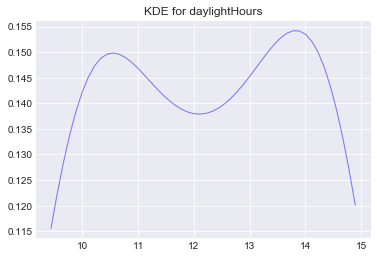

In [5]:
%matplotlib inline
# can use the density function to produce KDEs for any single variable
# nonparametric estimation of the pdf

fig, ax = plt.subplots()
density('daylightHours', bandwidth=1)

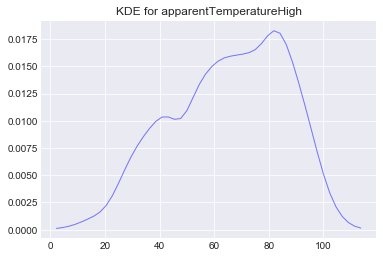

In [6]:
%matplotlib inline
fig, ax = plt.subplots()
density('apparentTemperatureHigh', bandwidth=4)

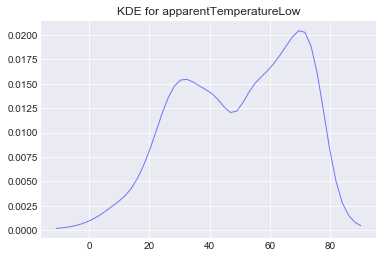

In [7]:
%matplotlib inline
fig, ax = plt.subplots()
density('apparentTemperatureLow', bandwidth=4)

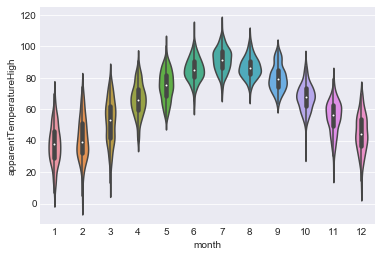

In [19]:
%matplotlib inline
sns.violinplot(x=df['month'], y=df['apparentTemperatureHigh'])

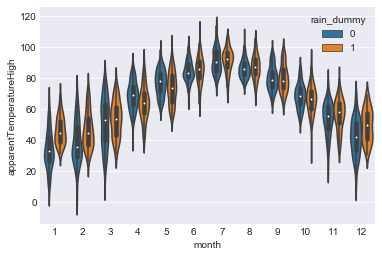

In [17]:
%matplotlib inline
sns.violinplot(x=df['month'], y=df['apparentTemperatureHigh'], hue=df['rain_dummy'])

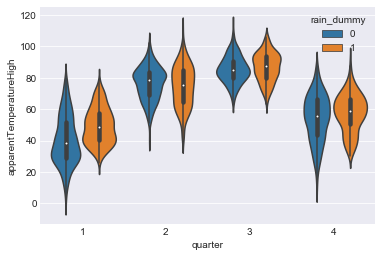

In [27]:
%matplotlib inline
sns.violinplot(x=df['quarter'], y=df['apparentTemperatureHigh'], hue=df['rain_dummy'])

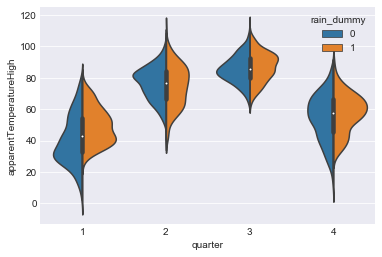

In [24]:
%matplotlib inline
sns.violinplot(x=df['quarter'], y=df['apparentTemperatureHigh'], hue=df['rain_dummy'], split=True)